In [1]:
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 1.6a: 本征值分解 Eigenvalue Decomposition

*   矩阵分解可被简单理解为“在一定约束条件下，将一个矩阵化成多个矩阵乘积的过程”。
*   **本征值分解数学形式：** $M = U\Lambda U^{\dagger}$ (其中 $\dagger$ 表示取转置复共轭)，即 $M_{ac} = \sum_{b} U_{ab}\Lambda_{bb}U^{*}_{cb}$。
*   **约束条件：**（1）变换矩阵的幺正性：$U^{\dagger}U = UU^{\dagger} = I$ ；(2) $\Lambda$为对角矩阵。

![eigenvalue-decomposition-tensor-network](images/eigenvalue_decomposition_tensor_network.png)

注意对角矩阵用菱形或者实心圆点表示，两条线段其实代表同一个 index

## 本征方程的解

*   本征值分解给出**本征方程**的解，即归一化向量$v$，满足 $Mv = \gamma v$
*   $U$ 的列向量给出本征方程的解，$\Lambda$的对角元给出本征值，满足 $MU_{:,n} = \Lambda_{n,n}U_{:,n}$
*   并不是任意矩阵都存在本征值分解！
*   厄密矩阵（$M = M^{\dagger}$）一定存在本征值分解，且本征值为实数。

### 本征方程的应用
* $M$ 可以是动力学的描述，$v$ 可以是动力学的一个稳定点
* $M$ 可以是一个旋转算符，例如旋转 180 度，那么直线可以理解为是这个旋转算符的本征方程的解




In [2]:
def rand_hermitian_matrix(dim: int) -> torch.Tensor:
    H = torch.randn(dim, dim, dtype=torch.complex64)
    H = H + H.conj().t()
    return H


def rand_real_symmetric_matrix(dim: int) -> torch.Tensor:
    mat = torch.randn(dim, dim, dtype=torch.float32)
    mat = (mat + mat.t()) / 2
    return mat

In [3]:
H = rand_hermitian_matrix(3)
print(f"Random Hermitian Matrix:\n{H}")

# To decompose a *Hermitian* matrix, use the `eigh` function
eigenvalues, u = torch.linalg.eigh(H)
print(f"Eigenvalues:\n{eigenvalues}")
print(f"EigenVectors:\n{u}")

reconstructed_H = u @ torch.diag(eigenvalues.to(torch.complex64)) @ u.conj().t()
error = (H - reconstructed_H).norm()
print(f"Error:\n{error}")

Random Hermitian Matrix:
tensor([[ 0.7797+0.0000j, -0.1058-0.0589j, -1.6081-0.5774j],
        [-0.1058+0.0589j, -0.5932+0.0000j,  1.3884+0.2970j],
        [-1.6081+0.5774j,  1.3884-0.2970j, -0.1371+0.0000j]])
Eigenvalues:
tensor([-2.2320, -0.1427,  2.4241])
EigenVectors:
tensor([[-0.3817+0.0000j,  0.6135+0.0000j, -0.6913-0.0000j],
        [ 0.5878-0.0540j,  0.7306-0.0984j,  0.3238-0.0575j],
        [-0.6749+0.2243j,  0.2595-0.1135j,  0.6029-0.2246j]])
Error:
5.909489573241444e-07


In [4]:
N = 1
# To test eigenvalue decomposition
v1 = eigenvalues[N] * u[:, N]
v2 = H @ u[:, N]
assert v1.allclose(v2)

## 本征值分解对应的优化问题

*   **本征值分解对应的优化问题**：求解归一化向量，满足 $\max_{|v|=1}(v^\dagger Mv)$，即
    * $v$ 要保证是单位向量，同时最大化 $v^\dagger Mv$
*   上述问题的解为 **M** 的最大本征值对应的 **本征向量**，$v^\dagger Mv$ 的值给出 **最大本征值**
*   考虑建立如下损失函数：
    $L = -\frac{v^\dagger Mv}{v^\dagger v}$
    * $v$ 不限制长度，所以要手动归一化
*   优化 $v$ 实现 $L$ 的极小化，即可得到 **M** 的最大本征值及对应的本征向量

### 证明
Presumption: We don't consider eigenvalue degeneration, so there's only one max eigenvalue.

Since $U$ is unitary, its columns are orthonormal so they can be basis vectors. Then we can express $v$ as a linear combination of the columns of $U$:
$$
v = Uc
$$
We also have that $v$ is unit vector, so
$$
v^\dagger v = c^\dagger U^\dagger Uc = c^\dagger c = 1
$$
Therefore, $c$ is a unit vector as well.

We now have
$$
v^\dagger M v = c^\dagger U^\dagger M U c = c^\dagger U^\dagger U \Lambda U^\dagger U c = c^\dagger \Lambda  c = \sum_k c_k^\dagger \Lambda_{kk} c_k
$$

Since $c$ is a unit vector  $\sum_k c_k^\dagger c_k = 1$, so the result can be considered as the weighted sum of all eigenvalues.

If and only if
$$
c_k = \left\{
\begin{array}{ll}
      1 & \text{if}\ k=0 \\
      0 & \text{otherwise}\\
\end{array}
\right.
$$
then we have the max value.


### 优化例子

In [5]:
dim = 8
lr = 2e-2
it_num = 300

# Generate a random real symmetric matrix (subset of Hermitian matrices)
mat = rand_real_symmetric_matrix(8)

v = torch.randn(dim, dtype=torch.float32, requires_grad=True)
adam = torch.optim.Adam([v], lr=lr)
losses = torch.zeros(it_num, dtype=torch.float32)

for t in tqdm(range(it_num)):
    # left out conjugate since v is real
    loss = -torch.einsum("a,ab,b", v, mat, v) / v.dot(v)
    loss.backward()
    adam.step()
    adam.zero_grad()
    losses[t] = loss.item()

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
found_max_eigenvalues = -losses
ref_eigenvalues = torch.linalg.eigvalsh(mat)
ref_max_eigenvalue = ref_eigenvalues.max()

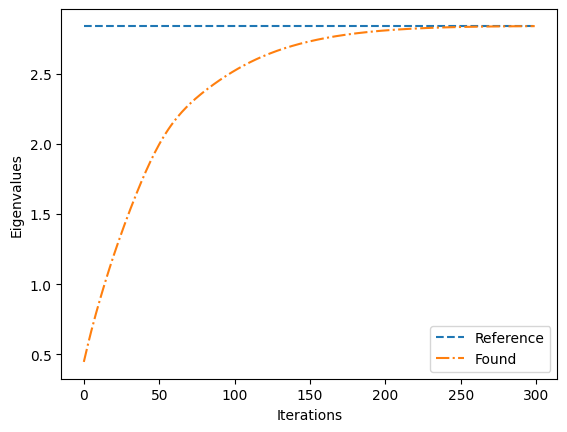

In [7]:
# plot
iterations = range(it_num)
fig, ax = plt.subplots()
ax.plot(iterations, torch.ones(it_num) * ref_max_eigenvalue, linestyle="--", label="Reference")
ax.plot(iterations, found_max_eigenvalues, linestyle="-.", label="Found")
ax.set_xlabel("Iterations")
ax.set_ylabel("Eigenvalues")
ax.legend()

### 任意线性映射的本征值分解

*   **任何线性映射**均可定义本征方程
    $f(v) = \gamma v$
*   使用scipy中的**线性算子 (LinearOperator)** 求解；
*   该方法对于复杂线性映射的处理十分有用，比如说一些线性映射的参数很少，但是如果写矩阵 $M$ 出来的话很麻烦或者很大，那么可以直接用线性算子来进行计算

In [8]:
from scipy.sparse.linalg import eigsh, LinearOperator

dim = 8
# M is a sparse real symmetric matrix, representing a linear map that has a few parameters compared to the size of the matrix
M = torch.eye(dim, dtype=torch.float32)
M[0, 7] = 1.
M[7, 0] = 1.

# Get the max eigenvalue with PyTorch
eigenvalues = torch.linalg.eigvalsh(M)
max_eigenvalue_torch = eigenvalues.max()

# Get the max eigenvalue with scipy
M_scipy = M.numpy()
eigenvalues, _ = eigsh(M_scipy, k=1, which="LA")
max_eigenvalue_scipy = eigenvalues[0]

# Get the max eigenvalue with LinearOperator
M2 = LinearOperator(shape=M_scipy.shape, matvec=lambda v: M_scipy @ v)
eigenvalues, _ = eigsh(M2, k=1, which="LA")
max_eigenvalue_linear_operator = eigenvalues[0]

print(f"torch: {max_eigenvalue_torch}, scipy: {max_eigenvalue_scipy}, LinearOperator: {max_eigenvalue_linear_operator}")

torch: 2.0, scipy: 2.0, LinearOperator: 2.0


# 1.6b: 本征方程的幂方法

**投影法**，用于求解 Hermitian Matrix 某个特定的本征值和本征向量


* **定义投影矩阵**: $\tau$ 一般取为一个小量；投影矩阵有不同的定义方法，求的是不同的本征向量，具体看证明
    * $\rho = e^{-\tau H}$
    * $\rho = e^{\tau H}$
    * $\rho = e^{\tau H^2}$
    * $\rho = e^{-\tau H^2}$
* $\rho$ 和 $H$ 具有相同的本征向量，本征值间为指数关系$e^{-\tau\Gamma}$，证明：
  假设 $H$ is Hermitian，那么用泰勒展开得

  $\rho = \sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} H^n = \sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} (U\Gamma U^{\dagger})^n = U (\sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} \Gamma^n) U^{\dagger}$

  $\rho$ 的本征值为 $\sum_{n=0}^{\infty} \frac{(-\tau)^n}{n!} \Gamma^n = e^{-\tau \Gamma}$
* 注意：$\rho$ 里的每个元素不是从 $H$ 的元素的简单指数，看上面的泰勒展开就知道了
* 投影属性：$\lim_{m\to\infty}\rho^m v = C U_{:,0}$, $C$ 是一个常数
    * 证明：TODO

## 算法
根据投影属性，可以做的是：
1. 随机生成一个 $v$，不断把 $\rho$ 和 $v$ 相乘，直到数值比较稳定
2. 这个时候我们得到 $C U_{:,0}$, $C$ 是一个常数，那么只要单位化就可以得到本征向量 $u$
3. 因为有 $M u = \gamma u$，同时乘上 $u^\dagger$ 得 $u^\dagger M u = u^\dagger \gamma u = \gamma$

这个算法的效率比 PyTorch, SciPy 里的低很多（对于矩阵来说），但是在张量网络的计算里比较有用


In [9]:
# ‘LM’ : Largest (in magnitude) eigenvalues.
# ‘SM’ : Smallest (in magnitude) eigenvalues.
# ‘LA’ : Largest (algebraic) eigenvalues.
# ‘SA’ : Smallest (algebraic) eigenvalues.
def eigs_power(mat: torch.Tensor, which: str, v0=None) -> (torch.Tensor, torch.Tensor):
    """
    :param mat: real symmetric matrix
    :param which: one of ["la", "sa", "lm", "sm"]
    :return: eigenvalue and eigenvector
    """
    which = which.lower()
    H = mat
    assert which in ["la", "sa", "lm", "sm"]
    assert H.allclose(H.t())
    assert len(H.shape) == 2

    TAU = 0.01
    if which == "la":
        rho = torch.matrix_exp(TAU * H)
    elif which == "lm":
        rho = torch.matrix_exp(TAU * torch.matrix_power(H, 2))
    elif which == "sa":
        rho = torch.matrix_exp(-TAU * H)
    elif which == "sm":
        rho = torch.matrix_exp(-TAU * torch.matrix_power(H, 2))
    else:
        raise NotImplementedError()

    ITER_NUM = 2000
    TOLERANCE = 1e-14
    if v0 is None:
        v = torch.randn(H.shape[1], dtype=H.dtype)
        v = v / v.norm()
    else:
        v = v0

    norm = 1.
    for _ in tqdm(range(ITER_NUM)):
        v_next = rho @ v
        norm = v_next.norm()
        v_next /= norm
        diff = (v_next - v).norm()
        if diff < TOLERANCE:
            break
        v = v_next

    scaled_eigenvector = H.matmul(v)  # eigenvalue * eigenvector
    # correct sign due to squaring
    sign = torch.sign(v.dot(scaled_eigenvector))

    if which == "la":
        return torch.log(norm) / TAU, scaled_eigenvector / scaled_eigenvector.norm()
    elif which == "sa":
        return -torch.log(norm) / TAU, scaled_eigenvector / scaled_eigenvector.norm()
    elif which == "lm":
        return sign * torch.sqrt(torch.log(norm) / TAU), scaled_eigenvector / scaled_eigenvector.norm()
    elif which == "sm":
        return sign * torch.sqrt(-torch.log(norm) / TAU), scaled_eigenvector / scaled_eigenvector.norm()

tc = torch
def eigs_power_ref(mat, v0=None, which='la', tau=0.01, it_time=2000, tol=1e-14):
    """
    :param mat: 输入矩阵（实对称阵）
    :param v0: 初始化向量，默认值为随机向量
    :param which: 计算哪个本征值与本征向量，
                  'la'为代数最大，'sa'为代数最小，'lm'为模最大，'sm'为模最小
    :param tau: 小的正实数，用以构造投影矩阵
    :param it_time: 最大迭代步数
    :param tol: 收敛阈值
    :return -tc.log(lm)/tau: 代数最大（tau>0）或最小（tau<0）的本征值
    :return v1: 对应的本征向量
    """
    # 初始化向量
    if v0 is None:
        v0 = tc.randn(mat.shape[1], dtype=mat.dtype)
        v0 /= v0.norm()
    v1 = v0.clone()

    # 根据which给出投影矩阵
    tau = abs(tau)
    if which.lower() == 'la':
        rho = tc.matrix_exp(tau * mat)
    elif which.lower() == 'sa':
        rho = tc.matrix_exp(-tau * mat)
    elif which.lower() == 'lm':
        rho = tc.matrix_exp(tau * (tc.matrix_power(mat, 2)))
    else:  # which.lower() == 'sm'
        rho = tc.matrix_exp(-tau * (tc.matrix_power(mat, 2)))

    lm = 1
    for n in range(it_time):  # 开始循环迭代
        v1 = rho.matmul(v0)  # 计算v1 = rho V0
        lm = v1.norm()  # 求本征值
        v1 /= lm  # 归一化v1
        # 判断收敛
        conv = (v1 - v0).norm()
        if conv < tol:
            break
        else:
            v0 = v1.clone()

    # 修正平方带来的符号丢失
    v1 = mat.matmul(v0)
    sign = tc.sign(v0.dot(v1))

    if which.lower() == 'la':
        return tc.log(lm)/tau, v1/v1.norm()
    elif which.lower() == 'sa':
        return -tc.log(lm)/tau, v1/v1.norm()
    elif which.lower() == 'lm':
        return sign * tc.sqrt(tc.log(lm)/tau), v1/v1.norm()
    else:  # which.lower() == 'sm'
        return sign * tc.sqrt(-tc.log(lm)/tau), v1/v1.norm()


In [10]:
for mode in ["la", "sa", "lm", "sm"]:
    mat = rand_real_symmetric_matrix(8)
    v = torch.randn(mat.shape[1], dtype=mat.dtype)
    v = v / v.norm()
    eigenvalue, eigenvector = eigs_power(mat, which=mode, v0=v)
    eigenvalue_ref, eigenvector_ref = eigs_power_ref(mat, which=mode, v0=v)
    assert eigenvalue.allclose(eigenvalue_ref), f"{mode} eigenvalue error"
    assert torch.allclose(eigenvector,
                          eigenvector_ref), f"{mode} eigenvector error, ref: {eigenvector_ref}, mine: {eigenvector}"

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
# FIXME: why eigs_power_ref is flaky?

for mode in ["la", "sa", "lm", "sm"]:
    mat = rand_real_symmetric_matrix(8)
    v01 = torch.randn(mat.shape[1], dtype=mat.dtype)
    vv01 = v01 / v01.norm()
    eigenvalue_1, eigenvector_1 = eigs_power_ref(mat, which=mode, v0=v01)
    v02 = torch.randn(mat.shape[1], dtype=mat.dtype)
    v02 = v02 / v02.norm()
    eigenvalue_2, eigenvector_2 = eigs_power_ref(mat, which=mode, v0=v02)
    assert eigenvalue_1.allclose(eigenvalue_2), f"{mode} eigenvalue error"
    assert torch.allclose(eigenvector_1,
                          eigenvector_2), f"{mode} eigenvector error, {eigenvector_1=}, {eigenvector_2=}"

AssertionError: sa eigenvector error, eigenvector_1=tensor([ 0.4553,  0.3518,  0.1939,  0.4266,  0.0183, -0.0109, -0.6677, -0.0561]), eigenvector_2=tensor([-0.4553, -0.3518, -0.1939, -0.4266, -0.0183,  0.0109,  0.6677,  0.0561])